# Preparar ambiente para execução
Fiz isso pra usar a base deles, mais tarde não usaremos

In [1]:
!git clone https://github.com/timothyyu/wsae-lstm.git

Cloning into 'wsae-lstm'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 712 (delta 0), reused 0 (delta 0), pack-reused 709
Receiving objects: 100% (712/712), 123.96 MiB | 35.95 MiB/s, done.
Resolving deltas: 100% (388/388), done.


### Instalar pacotes necessários

In [2]:
!pip install numpy pandas xlrd xlsxwriter matplotlib scikit-learn tensorflow keras PyWavelets scipy

     |████████████████████████████████| 143kB 3.2MB/s 


### Efetuar Imports

In [0]:
import numpy as np
import pandas as pd
import datetime as dt

from collections import OrderedDict
import xlrd
import xlsxwriter
import copy # copy.deepcopy - needed for non-shallow copy of odict object

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine learning imports
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
import tensorflow as tf
import keras
from keras.layers import Dense, LSTM, Input
from keras.models import Sequential, Model

import pywt # PyWavelets
from scipy import signal


# Dataset

### Carregar o dataset do arquivo xlsx

In [0]:
# Carregar de um arquivo excel e mapear cada planilha para um ordered dict
    
raw_xlsx_file = pd.ExcelFile("wsae-lstm/data/interim/clean_data.xlsx")
dict_dataframes = pd.read_excel(raw_xlsx_file,sheet_name = None)

### Listar todos os títulos das planilhas

In [5]:
print("\n".join(list(dict_dataframes.keys())))

csi300 index data
csi300 index future data
nifty 50 index data
nifty 50 index future data
hangseng index data
hangseng index future data
nikkei 225 index data
nikkei 225 index future data
s&p500 index data
s&p500 index future data
djia index data
djia index future data


### Separar as planilhas index das planilhas future

In [0]:
# Criar um novo dict de dataframes para as planilhas futures
dict_dataframes_future = copy.deepcopy(dict_dataframes)
# Criar um novo dict de dataframes para as planilhas index
dict_dataframes_index =  copy.deepcopy(dict_dataframes)

In [7]:
# Remover planilhas index do dict com as planilhas future
del dict_dataframes_future['csi300 index data']
del dict_dataframes_future['nifty 50 index data']
del dict_dataframes_future['hangseng index data']
del dict_dataframes_future['s&p500 index data']
del dict_dataframes_future['nikkei 225 index data']
del dict_dataframes_future['djia index data']

print('planilhas future:\n')
print("\n".join(list(dict_dataframes_future.keys())))

planilhas future:

csi300 index future data
nifty 50 index future data
hangseng index future data
nikkei 225 index future data
s&p500 index future data
djia index future data


In [8]:
# Remover planilhas futures do dict com as planilhas index
del dict_dataframes_index['csi300 index future data']
del dict_dataframes_index['nifty 50 index future data']
del dict_dataframes_index['hangseng index future data']
del dict_dataframes_index['s&p500 index future data']
del dict_dataframes_index['nikkei 225 index future data']
del dict_dataframes_index['djia index future data']

print('planilhas index:\n')
print("\n".join(list(dict_dataframes_index.keys())))

planilhas index:

csi300 index data
nifty 50 index data
hangseng index data
nikkei 225 index data
s&p500 index data
djia index data


### Transformar a coluna de data em índice do dataframe

In [9]:
# Visualização rápida do dataframe csi300
dict_dataframes_index['csi300 index data'].head()

,date,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
0,2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
1,2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2,2008-07-03,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
3,2008-07-04,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
4,2008-07-07,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


In [0]:
# Converter a coluna date para um objeto datetime para plot do gráfico
dict_dataframes_index['csi300 index data']['date'] = pd.to_datetime(dict_dataframes_index['csi300 index data']['date'].astype(str), format='%Y-%m-%d')
# Definir a coluna data como índice do dataframe
dict_dataframes_index['csi300 index data'] = dict_dataframes_index['csi300 index data'].set_index('date')

In [11]:
# Visualização rápida do dataframe csi300 após a mudança
dict_dataframes_index['csi300 index data'].head()

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
date,,,,,,,,,,,,,,,,,,,
2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2008-07-03,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
2008-07-04,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
2008-07-07,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


### Normalização dos dados

In [88]:
print('antes:')
print(dict_dataframes_index['csi300 index data'])

columns_names = dict_dataframes_index['csi300 index data'].columns
min_max_scaler = preprocessing.MinMaxScaler()
dict_dataframes_index['csi300 index data'] = min_max_scaler.fit_transform(dict_dataframes_index['csi300 index data'])
dict_dataframes_index['csi300 index data'] = pd.DataFrame(dict_dataframes_index['csi300 index data'], columns=columns_names)

print(40*'-')
print('later:')
print(dict_dataframes_index['csi300 index data'])

antes:
                 open       high        low  ...       roc       smi          wvad
date                                         ...                                  
2008-07-01  2799.2000  2809.3800  2690.1800  ... -9.424605 -0.097927 -8.726278e+07
2008-07-02  2702.6300  2745.9400  2670.0600  ... -8.557733 -0.026497 -1.095493e+08
2008-07-03  2654.4800  2807.6800  2617.2600  ... -2.886857 -0.031251 -5.855737e+07
2008-07-04  2751.2100  2783.8500  2716.0200  ... -8.338289 -0.017237 -7.467503e+07
2008-07-07  2747.6100  2890.9900  2747.6100  ...  3.955427  0.010701 -3.531151e+07
...               ...        ...        ...  ...       ...       ...           ...
2016-09-26  3267.6905  3267.6905  3220.2838  ... -3.660060 -0.029463 -2.297142e+08
2016-09-27  3214.8704  3240.7756  3214.4414  ... -2.995153 -0.006697 -9.168405e+07
2016-09-28  3243.6470  3243.6470  3227.9960  ... -3.254125 -0.009031 -1.528095e+08
2016-09-29  3234.8570  3257.7668  3234.8032  ... -2.219880  0.001744 -8.964788e+

### Plot da coluna close

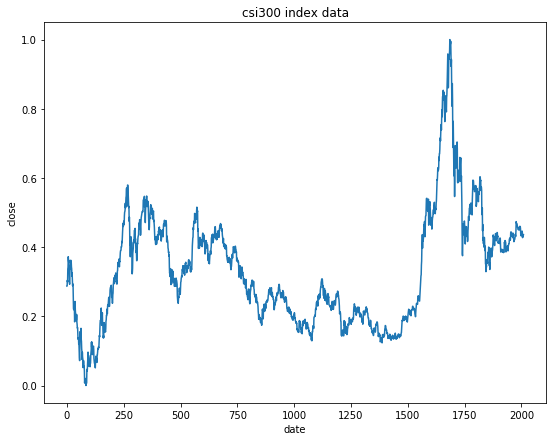

In [89]:
# Efetuar o plot utilizando o dataframe 'csi300 index data'
plt.figure(figsize=(9,7))
plt.title('csi300 index data')
plt.ylabel('close')
plt.xlabel('date')
plt.plot(dict_dataframes_index['csi300 index data'].index, dict_dataframes_index['csi300 index data']['close'])


### Separar entrada e saída

In [0]:
# Remover coluna close do dataset
x_data = dict_dataframes_index['csi300 index data'].drop(columns='close')

# Criar dataframe apenas com o close
y_data = dict_dataframes_index['csi300 index data']['close']
y_data = pd.DataFrame(y_data)

### Split de Dataset em treino e teste utilizando TimeSeriesSplit - não usar este split
Split sobre o índice


In [14]:
# Como funciona o TimeSeriesSplit
df = pd.DataFrame([k for k in range(0,20)])

splits = TimeSeriesSplit()
for train, test in splits.split(df):
  print(train, test)

[0 1 2 3 4] [5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17 18 19]


In [15]:
# Splitting do dataset em treino e teste, observando a restrição de séries temporais
train_list = []
test_list = []
X = dict_dataframes_index['csi300 index data'].values

splitter = TimeSeriesSplit(n_splits=6)
index = 1
for train_index, test_index in splitter.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Dias observados: %d' % (len(train) + len(test)))
    print('Dias de treino: %d' % (len(train)))
    print('Dias de teste: %d' % (len(test)))
    print(30*'-')
    train_list.append(train)
    test_list.append(test)
    index += 1

print('Treino:', len(train_list), 'Teste:', len(test_list))

Dias observados: 575
Dias de treino: 288
Dias de teste: 287
------------------------------
Dias observados: 862
Dias de treino: 575
Dias de teste: 287
------------------------------
Dias observados: 1149
Dias de treino: 862
Dias de teste: 287
------------------------------
Dias observados: 1436
Dias de treino: 1149
Dias de teste: 287
------------------------------
Dias observados: 1723
Dias de treino: 1436
Dias de teste: 287
------------------------------
Dias observados: 2010
Dias de treino: 1723
Dias de teste: 287
------------------------------
Treino: 6 Teste: 6


### Split de Dataset em treino e teste - usar este split

In [91]:
data = dict_dataframes_index['csi300 index data'].copy()

train_percent = 0.8
train_size = int(data.shape[0] * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]

print(len(train_data), len(test_data))

1608 402


# Remoção de ruídos

### Wavelength Transform utilizando Haar e level 2
Manual: [multi-level wavelet transform](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#pywt.wavedec)


### Calcular os coeficientes

In [0]:
# Calculando os coeficientes
coeffs = pywt.wavedec(train_list[0], 'haar', level=2)
cA2, cD2, cD1 = coeffs

### Plotando os coeficientes


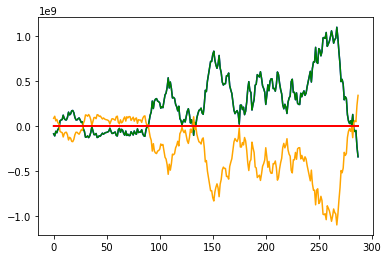

In [93]:
plt.plot(train_list[0],'blue', label='Original signal')
plt.plot(cA2,'green',label='cA2 - approximation coefficients array')
plt.plot(cD2,'orange',label= 'cD2 - Detail coefficient')
plt.plot(cD1,'red',label = 'cD1 - Detail coefficient')

### Função para calcular os coeficientes e reconstruir o sinal em uma transformação de level 2

In [0]:
def wavelet_reconst_l2(data):
    coeffs = pywt.wavedec(data, 'haar', level=2)
    cA2, cD2, cD1 = coeffs
    reconstructed_signal = pywt.waverec(coeffs, 'haar', mode = 'per')
    return reconstructed_signal

### Plotando resultado da transformação

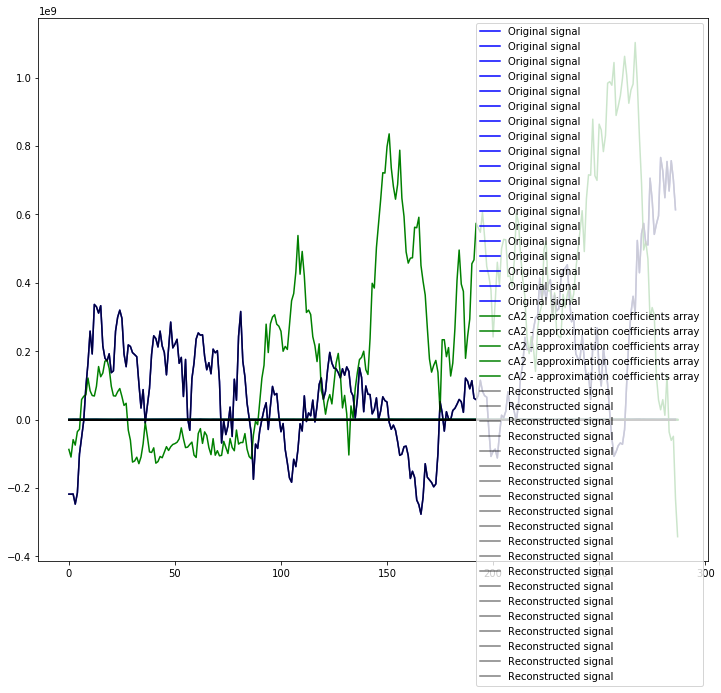

In [95]:
test_list_0_reconstructed = wavelet_reconst_l2(test_list[0])

plt.figure(figsize=(12,10))
plt.plot(test_list[0], 'blue', label='Original signal')
plt.plot(cA2, 'green', label='cA2 - approximation coefficients array')
plt.plot(test_list_0_reconstructed, 'black', label='Reconstructed signal', alpha=0.5)
plt.legend()
plt.show()

# Modelo Autoencoder

Este modelo utilizará 4 camadas internas e 10 neurônios para cada camada.<br/>
Será treinada cada camada interna por vez, utilizando a saída da camada interna anterior como entrada para a camada atual.

### Data

In [0]:
# Dataset
X = x_data

### Treinamento da primeira camada

In [99]:
# Parâmetros das camadas
input_dim = X.shape[1]
hidden_dim = 10
activation_function = 'sigmoid'
train_epochs = 10

# Modelo
stacked_autoencoder = Sequential()
# Entrada e Primeira camada interna
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function, input_shape=(input_dim,)) )
# Camada de saída
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )

stacked_autoencoder.compile(optimizer='sgd', loss='mse')
stacked_autoencoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                190       
_________________________________________________________________
dense_32 (Dense)             (None, 18)                198       
Total params: 388
Trainable params: 388
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Treinamento primeira camada
stacked_autoencoder.fit(X, X, epochs=train_epochs)

Epoch 1/10
2010/2010 [==============================] - 1s 431us/step - loss: 0.0706
Epoch 2/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0690
Epoch 3/10
2010/2010 [==============================] - 0s 38us/step - loss: 0.0675
Epoch 4/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0661
Epoch 5/10
2010/2010 [==============================] - 0s 33us/step - loss: 0.0646
Epoch 6/10
2010/2010 [==============================] - 0s 35us/step - loss: 0.0633
Epoch 7/10
2010/2010 [==============================] - 0s 35us/step - loss: 0.0620
Epoch 8/10
2010/2010 [==============================] - 0s 35us/step - loss: 0.0607
Epoch 9/10
2010/2010 [==============================] - 0s 34us/step - loss: 0.0594
Epoch 10/10
2010/2010 [==============================] - 0s 34us/step - loss: 0.0583


### Treinamento da segunda camada
Para treinar a segunda camada adicionaremos uma camada Dense entre a camada interna e a camada externa, e bloquearemos o treinamento da camada inicial, para não haver mudanças nos pesos na camada interna anterior

In [101]:
# Remover camada de decoder do primeiro AE
stacked_autoencoder.pop()

# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False

# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )

stacked_autoencoder.compile(optimizer='sgd', loss='mse')
stacked_autoencoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                190       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_34 (Dense)             (None, 18)                198       
Total params: 498
Trainable params: 308
Non-trainable params: 190
_________________________________________________________________


In [102]:
# Treinamento segunda camada
stacked_autoencoder.fit(X, X, epochs=train_epochs)

Epoch 1/10
2010/2010 [==============================] - 1s 429us/step - loss: 0.0912
Epoch 2/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0892
Epoch 3/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0872
Epoch 4/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0853
Epoch 5/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0834
Epoch 6/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0816
Epoch 7/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0798
Epoch 8/10
2010/2010 [==============================] - 0s 38us/step - loss: 0.0781
Epoch 9/10
2010/2010 [==============================] - 0s 41us/step - loss: 0.0765
Epoch 10/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0748


### Treinamento da terceira camada

In [103]:
# Remover camada de decoder do segundo AE
stacked_autoencoder.pop()

# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False

# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )

stacked_autoencoder.compile(optimizer='sgd', loss='mse')
stacked_autoencoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                190       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_36 (Dense)             (None, 18)                198       
Total params: 608
Trainable params: 308
Non-trainable params: 300
_________________________________________________________________


In [104]:
# Treinamento terceira camada
stacked_autoencoder.fit(X, X, epochs=train_epochs)

Epoch 1/10
2010/2010 [==============================] - 1s 463us/step - loss: 0.0760
Epoch 2/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0744
Epoch 3/10
2010/2010 [==============================] - 0s 35us/step - loss: 0.0727
Epoch 4/10
2010/2010 [==============================] - 0s 41us/step - loss: 0.0712
Epoch 5/10
2010/2010 [==============================] - 0s 38us/step - loss: 0.0697
Epoch 6/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0682
Epoch 7/10
2010/2010 [==============================] - 0s 38us/step - loss: 0.0668
Epoch 8/10
2010/2010 [==============================] - 0s 43us/step - loss: 0.0654
Epoch 9/10
2010/2010 [==============================] - 0s 41us/step - loss: 0.0640
Epoch 10/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0627


### Treinamento da quarta camada

In [105]:
# Remover camada de decoder do terceiro AE
stacked_autoencoder.pop()

# Bloquear atualização de pesos e bias da camada interna anterior
previous_layer = stacked_autoencoder.get_layer(index=-1)
previous_layer.trainable = False

# Adicionar nova camada interna e camada de decoder
stacked_autoencoder.add( Dense(hidden_dim, activation=activation_function) )
stacked_autoencoder.add( Dense(input_dim, activation=activation_function) )

stacked_autoencoder.compile(optimizer='sgd', loss='mse')
stacked_autoencoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                190       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_35 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_37 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_38 (Dense)             (None, 18)                198       
Total params: 718
Trainable params: 308
Non-trainable params: 410
_________________________________________________________________


In [106]:
# Treinamento quarta camada
stacked_autoencoder.fit(X, X, epochs=train_epochs)

Epoch 1/10
2010/2010 [==============================] - 1s 503us/step - loss: 0.0862
Epoch 2/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0841
Epoch 3/10
2010/2010 [==============================] - 0s 38us/step - loss: 0.0820
Epoch 4/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0800
Epoch 5/10
2010/2010 [==============================] - 0s 36us/step - loss: 0.0781
Epoch 6/10
2010/2010 [==============================] - 0s 41us/step - loss: 0.0762
Epoch 7/10
2010/2010 [==============================] - 0s 38us/step - loss: 0.0744
Epoch 8/10
2010/2010 [==============================] - 0s 39us/step - loss: 0.0727
Epoch 9/10
2010/2010 [==============================] - 0s 37us/step - loss: 0.0710
Epoch 10/10
2010/2010 [==============================] - 0s 40us/step - loss: 0.0693


# Modelo LSTM

### Preparar a entrada e saída para o modelo

In [0]:
# Extrair entrada e saída do treinamento
x_train = train_data.copy().drop(columns=['close'])
x_train = x_train.values
y_train = train_data.copy()['close']
y_train = pd.DataFrame(y_train).values

# Extrair entrada e saída do teste
x_test = test_data.copy().drop(columns=['close'])
x_test = x_test.values
y_test = test_data.copy()['close']
y_test = pd.DataFrame(y_test).values

In [108]:
# Ajustar as dimensões da entrada para a camada LSTM
x_train_lstm = x_train.copy().reshape((x_train.shape[0], x_train.shape[1], 1))
# x_train_lstm = x_train.copy()
# y_train_lstm = y_train.copy().reshape((1, y_train.shape[0], y_train.shape[1]))
y_train_lstm = y_train.copy()

x_test_lstm = x_test.copy().reshape((x_test.shape[0], x_test.shape[1], 1))
# x_test_lstm = x_test.copy()
# y_test_lstm = y_test.copy().reshape((1, y_test.shape[0], y_test.shape[1]))
y_test_lstm = y_test.copy()

print('train:', x_train_lstm.shape, y_train_lstm.shape, 'test:', x_test_lstm.shape, y_test_lstm.shape)

train: (1608, 18, 1) (1608, 1) test: (402, 18, 1) (402, 1)


### Criação do Modelo

In [109]:
# Adicionar camada LSTM
neurons_lstm = 50

# input_layer = Input(shape=(1,1))

# lstm_layer = LSTM(neurons_lstm, return_sequences=False)(input_layer)

# output_layer = Dense(1, activation='relu')(lstm_layer)

predictor = Sequential()

predictor.add( LSTM(neurons_lstm, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])) )
# Adicionar camada de output
predictor.add( Dense(1) )

# predictor = Model(inputs=input_layer, outputs=output_layer)

predictor.compile(optimizer= 'sgd', loss='mse')
predictor.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Treinamento do modelo

In [114]:
epochs = 200

print(x_train_lstm.shape, y_train_lstm.shape)

predictor.fit(x_train_lstm, y_train_lstm, epochs=epochs)

(1608, 18, 1) (1608, 1)
Epoch 1/200
1608/1608 [==============================] - 1s 494us/step - loss: 0.0040
Epoch 2/200
1608/1608 [==============================] - 1s 495us/step - loss: 0.0040
Epoch 3/200
1608/1608 [==============================] - 1s 509us/step - loss: 0.0039
Epoch 4/200
1608/1608 [==============================] - 1s 534us/step - loss: 0.0039
Epoch 5/200
1608/1608 [==============================] - 1s 505us/step - loss: 0.0038
Epoch 6/200
1608/1608 [==============================] - 1s 515us/step - loss: 0.0038
Epoch 7/200
1608/1608 [==============================] - 1s 493us/step - loss: 0.0038
Epoch 8/200
1608/1608 [==============================] - 1s 498us/step - loss: 0.0037
Epoch 9/200
1608/1608 [==============================] - 1s 479us/step - loss: 0.0037
Epoch 10/200
1608/1608 [==============================] - 1s 476us/step - loss: 0.0037
Epoch 11/200
1608/1608 [==============================] - 1s 476us/step - loss: 0.0036
Epoch 12/200
1608/1608 [====

### Predizer valores no conjunto de teste

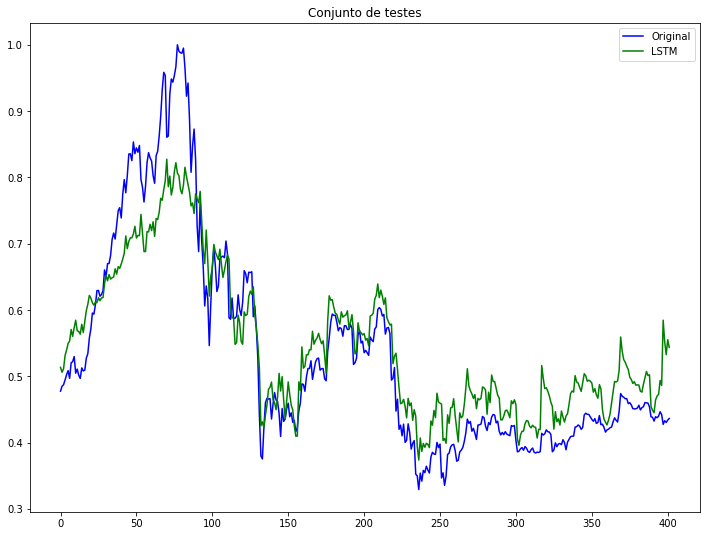

In [118]:
predicted = predictor.predict(x_test_lstm)

plt.figure(figsize=(12,9))
plt.title('Conjunto de testes')
plt.plot(y_test_lstm[:, 0], 'blue', label='Original')
plt.plot(predicted, 'green', label='LSTM')
plt.legend()
plt.show()

### Predizer valores em cima do conjunto de treino

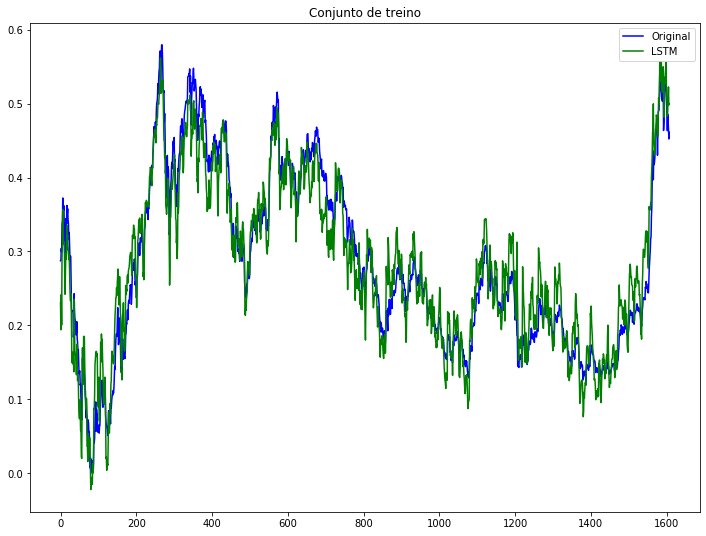

In [123]:
predicted = predictor.predict(x_train_lstm)

plt.figure(figsize=(12,9))
plt.title('Conjunto de treino')
plt.plot(y_train_lstm[:, 0], 'blue', label='Original')
plt.plot(predicted, 'green', label='LSTM')
plt.legend()
plt.show()